In [1]:
import torch
import pickle as pkl
import numpy as np
import sys
import cmocean
from data_loader.datasets import DriveDataset
from skimage.filters import frangi
from sklearn import metrics
from scipy.ndimage import  gaussian_filter as gblur
from matplotlib import pyplot as plt
import argparse
import seaborn as sns
import cv2
%pylab
%matplotlib inline
from sklearn import metrics as M

Using matplotlib backend: agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = 'train_vesselness.pkl'
with open(filename, 'rb') as fi:
    vessels = pkl.load(fi)
    
with open('train_analysis.pkl', 'rb') as fi:
    data = torch.load(fi)

In [3]:
dataset = DriveDataset( "/pghbio/dbmi/batmanlab/rohit33/DRIVE/", train=True, augment=False)
gtdataset = DriveDataset( "/pghbio/dbmi/batmanlab/rohit33/DRIVE/", train=True, toy=True, augment=False)

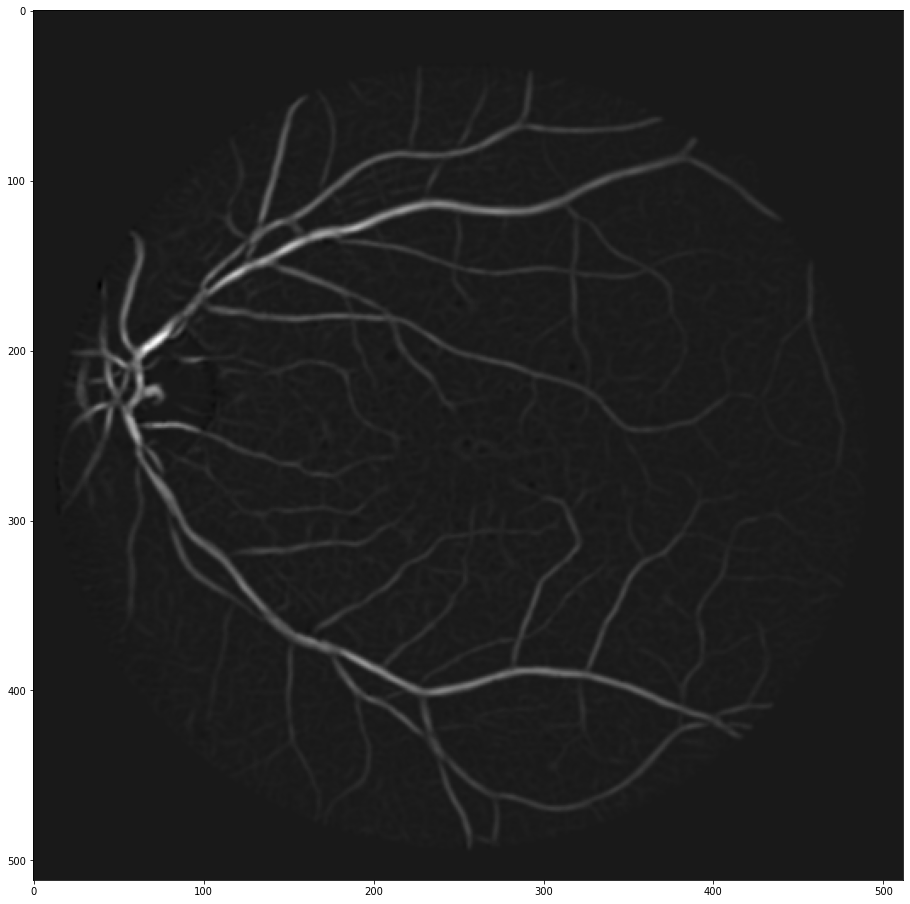

In [4]:
plt.figure(figsize=(16, 16))
plt.imshow(vessels[0, 0], 'gray')

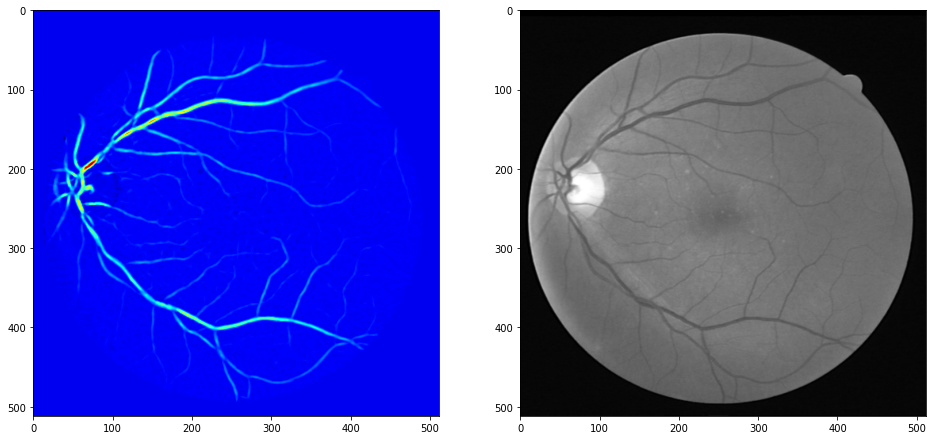

In [5]:
plt.figure(figsize=(16, 16))
I = 0
for i in range(I, I+1):
    img = dataset[i]['image'][0].data.cpu().numpy()
    lab = gtdataset[i]['image'][0].data.cpu().numpy()
    lab = (lab > 0.5).astype(int)
    mask = dataset[i]['mask'][0].data.cpu().numpy()
    # Get vesselness
#     ves = frangi_vesselness(img, i)
    ves = vessels[i, 0]
    ves = (ves - ves.min())/(ves.max() - ves.min())
#     ves = ves * mask
    plt.subplot(121)
    plt.imshow(ves, 'jet')
    plt.subplot(122)
    plt.imshow(img, 'gray')
#     plt.imshow(ves**(0.5), 'jet')
#     plt.imshow(ves > np.percentile(ves, 90))
    # plt.savefig('label.png')
#     auc = AUC(ves, lab)
#     print(auc)


In [6]:
len(dataset)

20

In [7]:
data['data'].keys()

dict_keys(['image', 'mask'])

In [8]:
data['output'].keys()

dict_keys(['recon', 'vessel', 'bangle', 'bwt'])

In [9]:
data['data']['image'].shape

torch.Size([20, 1, 512, 512])

In [10]:
data['output']['vessel'].shape

torch.Size([20, 4, 512, 512])

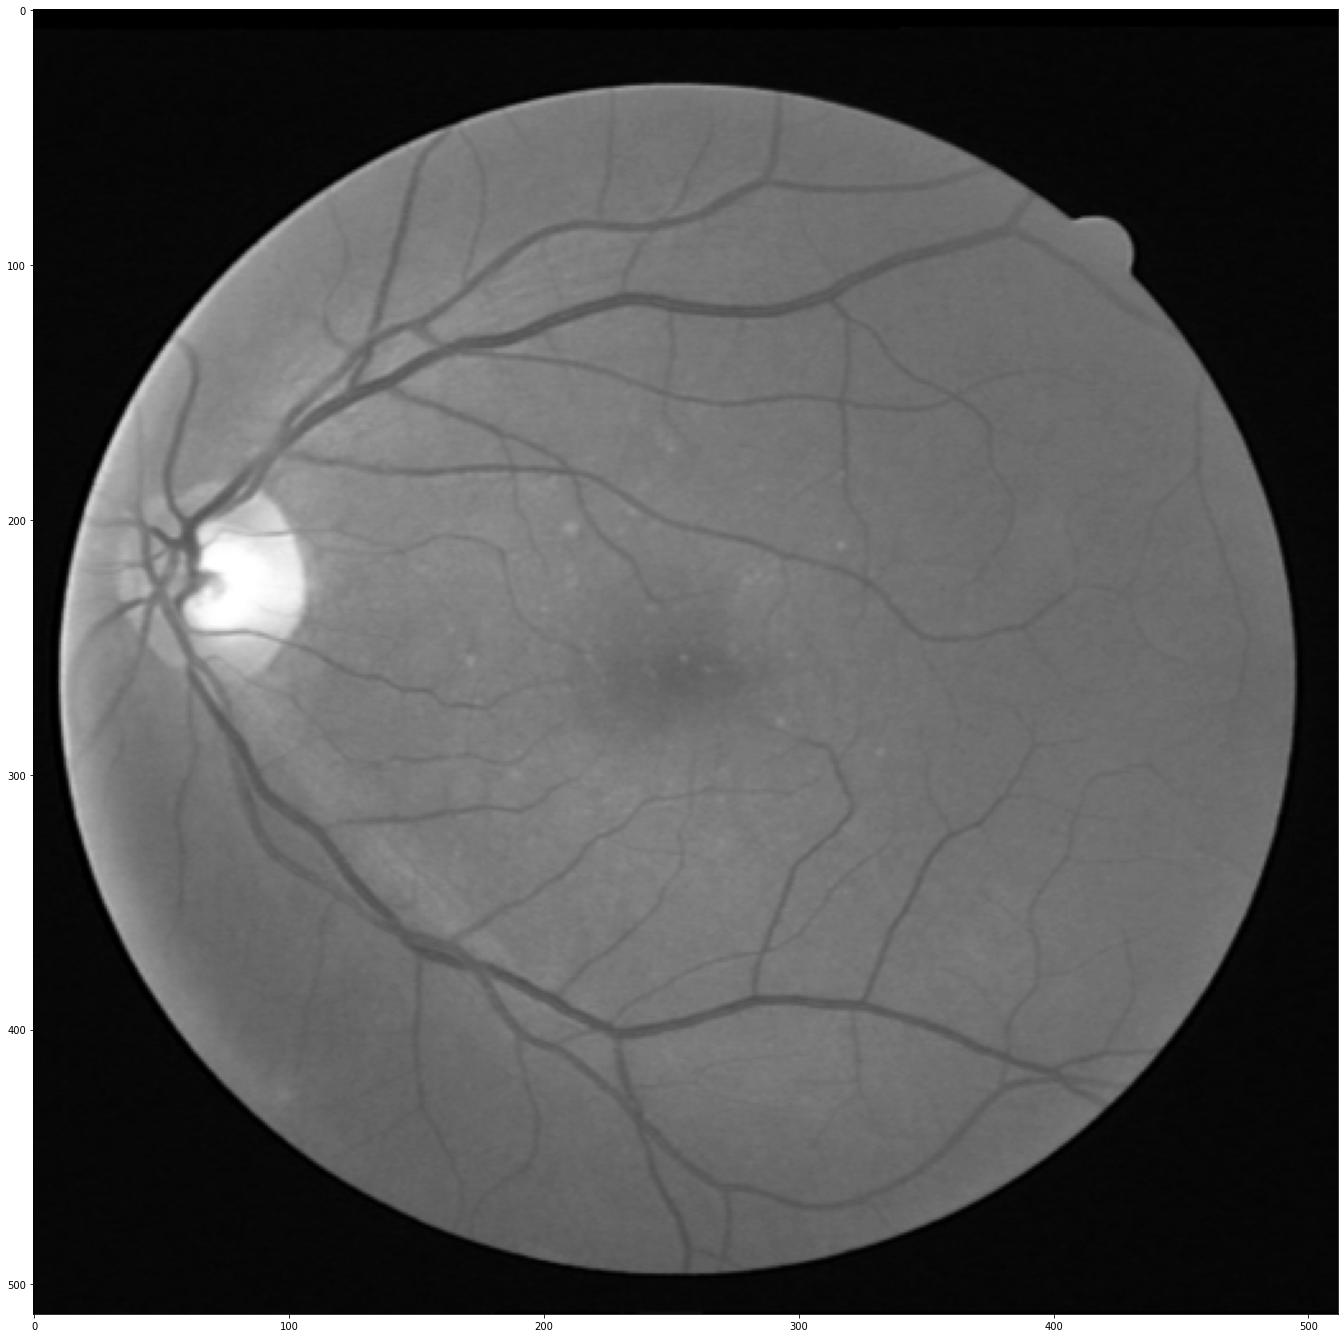

In [11]:
plt.figure(figsize=(24, 24))
plt.imshow(dataset[I]['image'][0].data.cpu().numpy(), 'gray')

In [12]:
vy, vx = data['output']['vessel'][I, 2:].data.cpu().numpy() + 0

In [13]:
# Smooth vectors
# vy = gblur(vy, 1)*dataset[I]['mask'][0].data.cpu().numpy()
# vx = gblur(vx, 1)*dataset[I]['mask'][0].data.cpu().numpy()

In [14]:
# Get norm
# norm = np.sqrt(vy**2 + vx**2)
norm = vx*0 + 1
ang = np.arctan2(vx, vy)

(-0.5, 49.5, 49.5, -0.5)

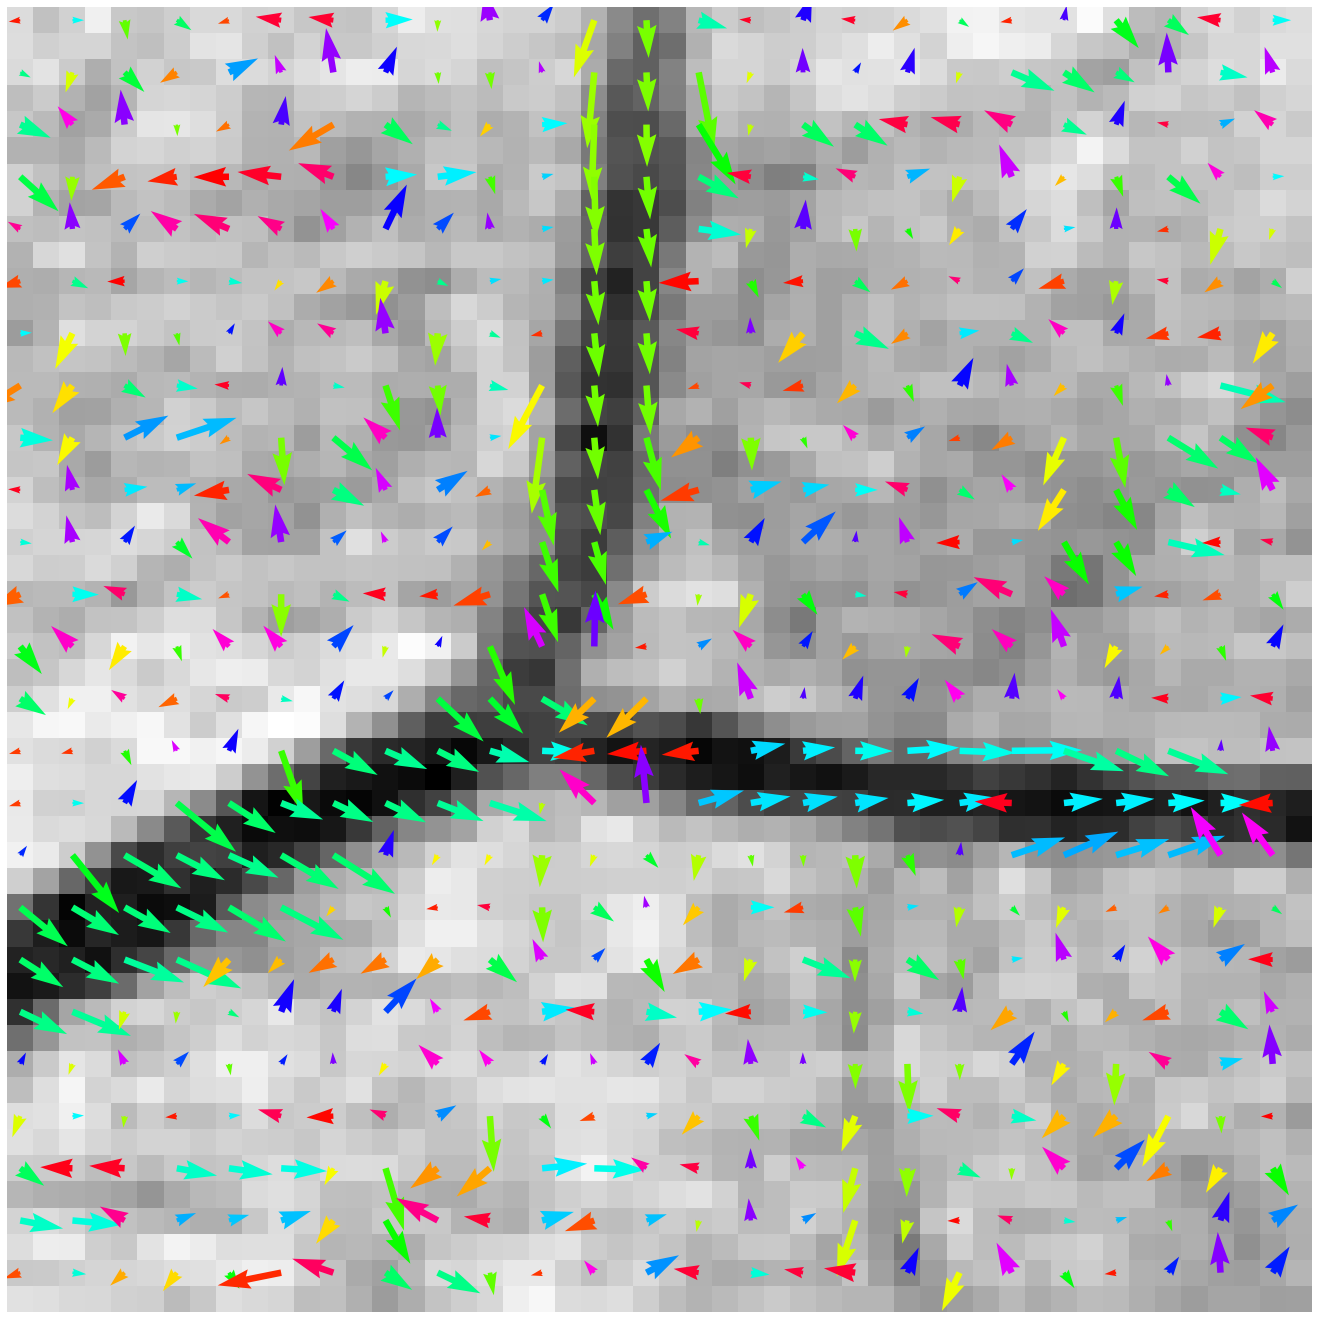

In [15]:
y1 = 40
y2 = 90
x1 = 268
x2 = 318

# y1 = 0
# y2 = dataset[2]['image'][0].shape[0]
# x1 = 0
# x2 = dataset[2]['image'][0].shape[1]

N = 2

xarr = np.arange(x1, x2, N) - x1
yarr = np.arange(y1, y2, N) - y1
xarr, yarr = np.meshgrid(xarr, yarr)

dummy = dataset[I]['image'][0][y1:y2, x1:x2].data.cpu().numpy()*0
dummy[2, 2] = 1

plt.figure(figsize=(24, 24))
plt.quiver(xarr, yarr, 
           vy[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
           vx[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
           ang[y1:y2:N, x1:x2:N],
           width=0.005,
          cmap='hsv',
)
plt.imshow(dataset[I]['image'][0][y1:y2, x1:x2].data.cpu().numpy(), 'gray')
# plt.imshow(dummy, 'gray')
plt.axis('off')

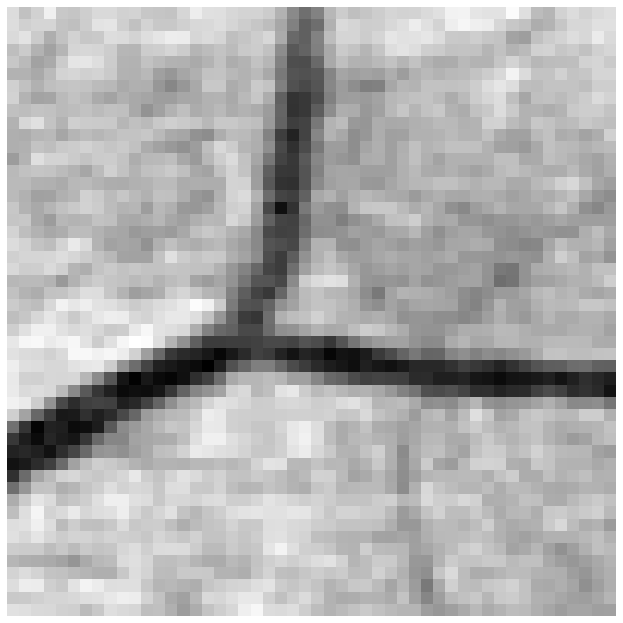

In [22]:
f = plt.figure(figsize=(24, 24))
ax = f.add_subplot(121)
# ax.quiver(xarr, yarr, 
#            vy[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
#            vx[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
#            ang[y1:y2:N, x1:x2:N],
#           width=0.006,
# #           cmap=sns.color_palette('hls', 314, as_cmap=True)
#           cmap=cmocean.cm.phase
# )
ax.imshow(dataset[I]['image'][0][y1:y2, x1:x2].data.cpu().numpy(), 'gray')
# ax.imshow(vessels[I, 0][y1:y2, x1:x2], 'gray')
# ax.imshow(dummy, 'gray')
ax.set_axis_off()
ax.set_aspect('equal')
plt.savefig("intensity.png", bbox_inches='tight', dpi=300, transparent=True)
# plt.savefig("vessels.png", bbox_inches='tight', dpi=300, transparent=True)

In [182]:
theta1, theta2 = data['output']['bangle'][I]

In [183]:
theta1

tensor([[6.7458e-04, 8.7235e-05, 3.9977e-05,  ..., 5.6144e-05, 2.0343e-04,
         7.6876e-04],
        [4.7728e-05, 3.6471e-06, 1.3090e-06,  ..., 1.4414e-06, 6.2843e-06,
         1.1031e-04],
        [3.7382e-05, 1.8503e-06, 3.8992e-07,  ..., 4.7644e-07, 2.7318e-06,
         6.9528e-05],
        ...,
        [7.8763e-04, 1.1497e-04, 1.1879e-05,  ..., 1.0208e-05, 2.1409e-04,
         2.1495e-03],
        [6.9685e-03, 1.8381e-03, 5.8487e-04,  ..., 4.4407e-04, 1.9940e-02,
         6.9915e-03],
        [1.3077e-02, 6.2496e-02, 9.3209e-03,  ..., 5.5411e-03, 1.5556e-02,
         2.3203e-03]])

## Bifurcation angles

In [188]:
theta1[y1+20:y1+40, x1:x1+10] = 0

In [189]:
cos = torch.cos(theta1).data.numpy()
sin = torch.sin(theta1).data.numpy()

vx1 = vx*cos - vy*sin
vy1 = vx*sin + vy*cos

In [190]:
cos = torch.cos(-theta2).data.numpy()
sin = torch.sin(-theta2).data.numpy()

vx2 = vx*cos - vy*sin
vy2 = vx*sin + vy*cos

ValueError: Argument U has a size 289 which does not match 625, the number of arrow positions

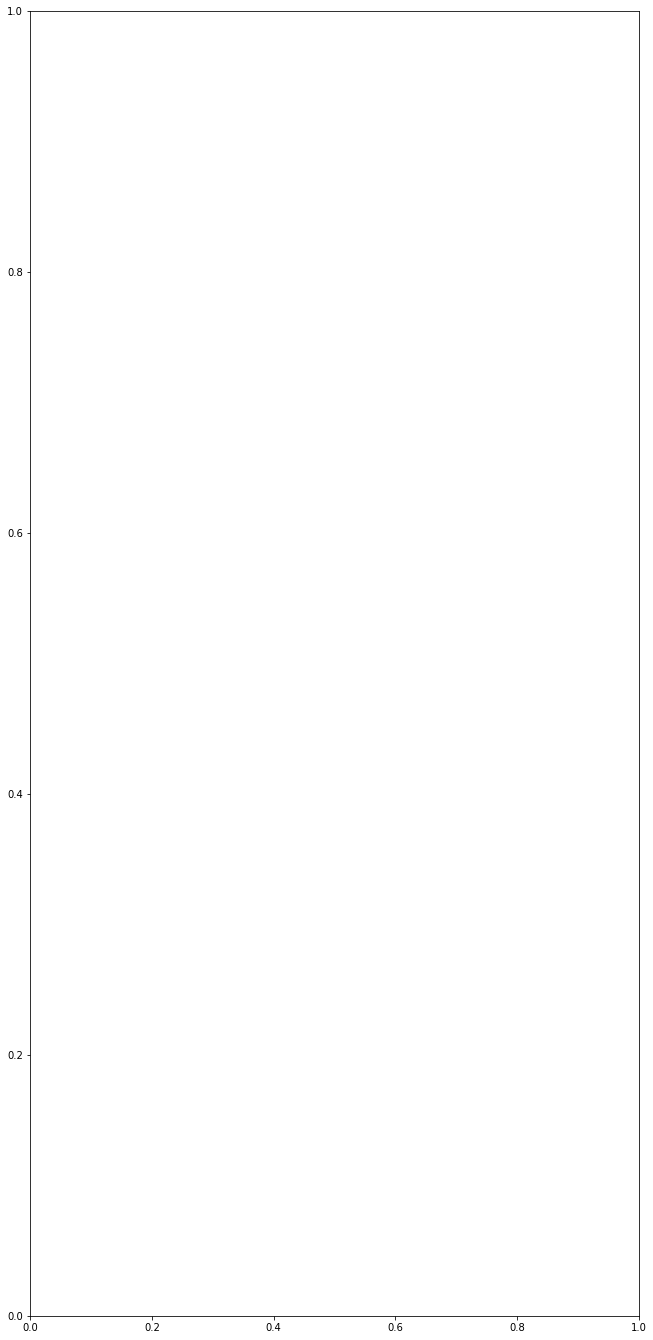

In [197]:
f = plt.figure(figsize=(24, 24))
ax = f.add_subplot(121)
N=3
ax.quiver(xarr, -yarr, 
           vy1[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
           vx1[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
          width=0.006,
          color='red',
)
ax.quiver(xarr, -yarr, 
           vy2[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
           vx2[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
          width=0.006,
          color='blue',
)
ax.quiver(xarr, -yarr, 
           vy[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
           vx[y1:y2:N, x1:x2:N]/norm[y1:y2:N, x1:x2:N], 
          width=0.006,
          color='lightgray',
)
ax.set_axis_off()
ax.set_aspect('equal')

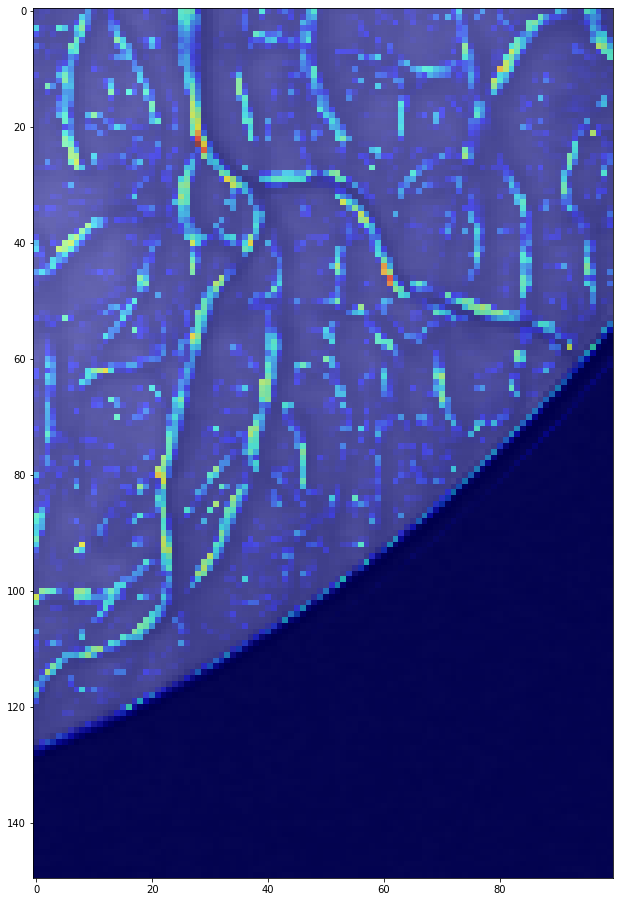

In [19]:
plt.figure(figsize=(16, 16))
plt.imshow(theta1[y1:y2, x1:x2], 'jet')
plt.imshow(dataset[2]['image'][0][y1:y2, x1:x2].data.cpu().numpy(), 'gray', alpha=0.4)